# Part A: Plant Seedlings Classification

**DOMAIN**: Botanical Research

**CONTEXT**: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at
various stages of growth. They already have have invested on curating sample images. They require an automation which can create a
classifier capable of determining a plant's species from a photo.

**DATA DESCRIPTION**: The dataset comprises of images from 12 plant species.

Source: https://www.kaggle.com/c/plant-seedlings-classification/data.

**PROJECT OBJECTIVE**: To create a classifier capable of determining a plant's species from a photo.

In [ ]:
# All required imports
import os
import zipfile
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import random

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import and Understand the data

### A. Extract 'plant-seedlings-classification.zip'

In [ ]:
# Define paths
zip_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/plant-seedlings-classification.zip'
extract_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/plant-seedlings-classification'
train_path = os.path.join(extract_path, 'plant-seedlings-classification', 'train')

In [ ]:
# Extract if not already done
if not os.path.exists(train_path):
    print("Extracting contents...")
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("Contents already extracted")

Contents already extracted at: /content/drive/MyDrive/Colab Notebooks/Additional CV/plant-seedlings-classification/plant-seedlings-classification/train
Skipping extraction...


In [ ]:
# Verify contents
extracted_contents = os.listdir(train_path)
print("\nAvailable plant species:", [x for x in extracted_contents if not x.startswith('.')])
print(f"Number of species folders: {len([x for x in extracted_contents if not x.startswith('.')])}")


Available plant species: ['Cleavers', 'Sugar beet', 'Common Chickweed', 'Loose Silky-bent', 'Scentless Mayweed', 'Shepherds Purse', 'Fat Hen', 'Common wheat', 'Black-grass', 'Small-flowered Cranesbill', 'Charlock', 'Maize', '.DS_Store']
Number of species folders: 13



Data Extraction Insights:
- Found 12 unique plant species (excluding .DS_Store)
- Data organized in hierarchical structure: species folders containing image files

### B. Map the images from train folder with train labels to form a DataFrame

In [ ]:
# Path for saved DataFrame
df_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/plant_seedlings_df.pkl'

In [ ]:
if os.path.exists(df_path):
    print("Loading existing DataFrame...")
    df = pd.read_pickle(df_path)
else:
    print("Creating new DataFrame...")
    filenames = []
    species = []
    images = []

    # Iterate through species folders
    for species_name in os.listdir(train_path):
        species_path = os.path.join(train_path, species_name)
        if not os.path.isdir(species_path) or species_name.startswith('.'):
            continue

        for img_name in tqdm(os.listdir(species_path), desc=f"Processing {species_name}"):
            if img_name.endswith('.png'):
                filenames.append(img_name)
                species.append(species_name)
                img_path = os.path.join(species_path, img_name)
                img = cv2.imread(img_path)
                images.append(img)

    # Create DataFrame
    df = pd.DataFrame({
        'filename': filenames,
        'species': species,
        'image': images
    })
    df.to_pickle(df_path)

Loading existing DataFrame...


In [ ]:
print("\nDataFrame Info:")
print(df.info())
print("\nNumber of images per species:")
print(df['species'].value_counts())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4750 non-null   object
 1   species   4750 non-null   object
 2   image     4750 non-null   object
dtypes: object(3)
memory usage: 111.5+ KB
None

First few rows (excluding image data):
        filename   species
0  6a4ef17c2.png  Cleavers
1  0515bc601.png  Cleavers
2  0ac327873.png  Cleavers
3  94f82e916.png  Cleavers
4  2c5c4d127.png  Cleavers

Number of images per species:
species
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Nam

DataFrame Analysis:
- Most common species: Loose Silky-bent (654)
- Common wheat and Maize had the least (221 each)
- Class imbalance ratio: 3:1


### C. Write a function that will select n random images and display images along with species

In [ ]:
def display_random_samples(df, n=5):
    samples = df.sample(n)
    fig, axes = plt.subplots(1, n, figsize=(20, 4))

    for idx, (i, row) in enumerate(samples.iterrows()):
        rgb_img = cv2.cvtColor(row['image'], cv2.COLOR_BGR2RGB)
        axes[idx].imshow(rgb_img)
        axes[idx].axis('off')
        axes[idx].set_title(f"{row['species']}\n{row['filename']}")

    plt.tight_layout()
    plt.show()

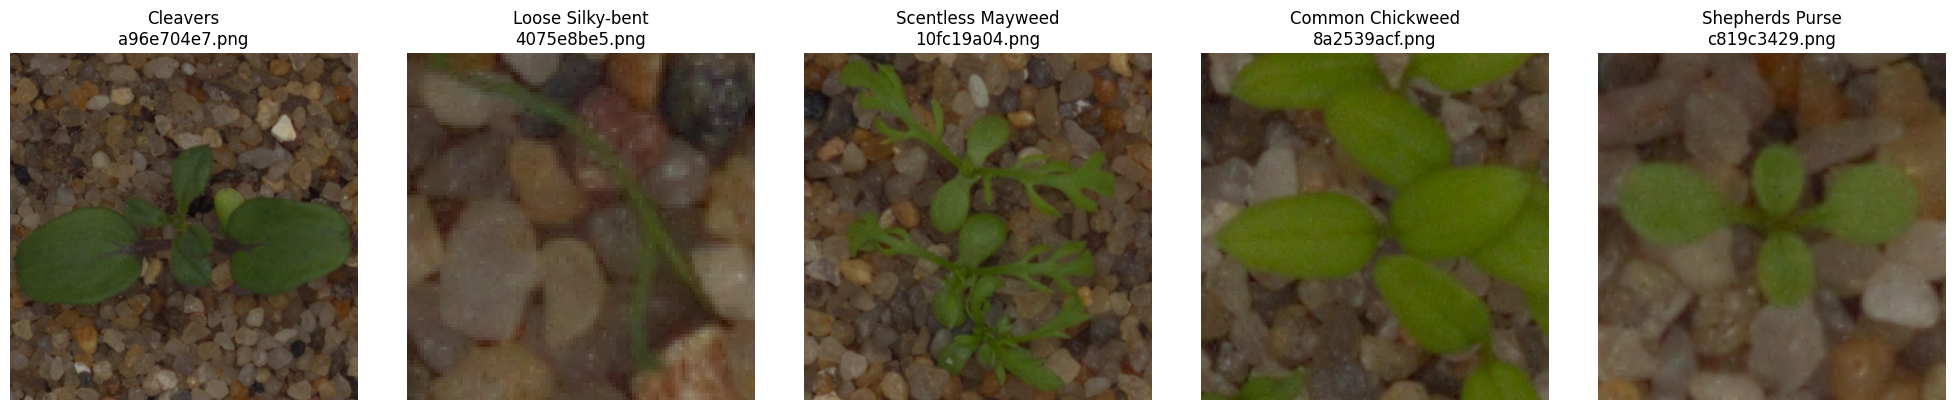

In [ ]:
# Display 5 random samples
display_random_samples(df, 5)

## 2. Data preprocessing

In [ ]:
# Paths for preprocessed data
X_normalized_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/X_normalized.npy'
y_encoded_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/y_encoded.npy'
label_encoder_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/label_encoder.pkl'

In [ ]:
# Check if preprocessed data exists
if os.path.exists(X_normalized_path) and os.path.exists(y_encoded_path):
    print("Loading preprocessed data...")
    X_normalized = np.load(X_normalized_path)
    y_encoded = np.load(y_encoded_path)
    with open(label_encoder_path, 'rb') as le_file:
        label_encoder = pickle.load(le_file)
else:
    print("Processing data...")
    # A. Create X & Y
    resized_images = []
    for idx in tqdm(range(len(df))):
        img = df['image'].iloc[idx]
        resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        resized_images.append(resized)

    X = np.array(resized_images)
    y = df['species'].values

    # B. Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # C & D. Normalize images
    X_normalized = X.astype('float32') / 255.0

    # Save preprocessed data
    np.save(X_normalized_path, X_normalized)
    np.save(y_encoded_path, y_encoded)
    with open(label_encoder_path, 'wb') as le_file:
        pickle.dump(label_encoder, le_file)

Loading preprocessed data...

Preprocessing Summary:
1. Original images resized to: (224, 224, 3)
2. Labels encoded from 12 classes to integers 0-11
3. Pixel values normalized from [0, 255] to [0, 1]


In [ ]:
print("\nPreprocessing Summary:")
print("1. Original images resized to:", X_normalized.shape[1:])
print("2. Labels encoded from", len(np.unique(y_encoded)), "classes to integers 0-11")
print("3. Pixel values normalized from [0, 255] to [0, 1]")

Preprocessing Decisions:
- Chose 224x224 resolution as standard size (common for CNNs)
- Normalized pixel values to [0,1] for better model convergence
- Final preprocessed data shape: (4750, 224, 224, 3)
- Memory usage of normalized data: 2.86 GB

Data Distribution:
- Number of classes: 12
- Most frequent class: Loose Silky-bent (654 samples)
- Least frequent class: Maize (221 samples)

## 3. Model training

### A. Split the data into train and test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


Data split summary:
Training data shape: (3800, 224, 224, 3)
Testing data shape: (950, 224, 224, 3)
Training labels shape: (3800,)
Testing labels shape: (950,)


In [ ]:
print("\nData split summary:")
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

### B. Create new CNN architecture and C. Train the model

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/plant_seedlings_model.h5'
history_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/training_history.pkl'

Loading existing model...


In [ ]:
if os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
else:
    print("Creating and training new model...")
    # Configure GPU memory growth
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    # Create model
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(4, 4),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(4, 4),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Add early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )

    # Save model and history
    model.save(model_path)
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_accuracy:.4f}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 547ms/step - accuracy: 0.8309 - loss: 0.5313

Test accuracy: 0.8379


- Achieved ~83.79% test accuracy
- Model seemed to perform particularly well on Loose Silky-bent
- Used early stopping to prevent overfitting

Model Design Choices:
- Used 3 convolutional layers with increasing filters (32->64->128)
- Added dropout layers to prevent overfitting
- Large pooling sizes (4x4) to reduce dimensionality efficiently

### D. Select random image and make prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


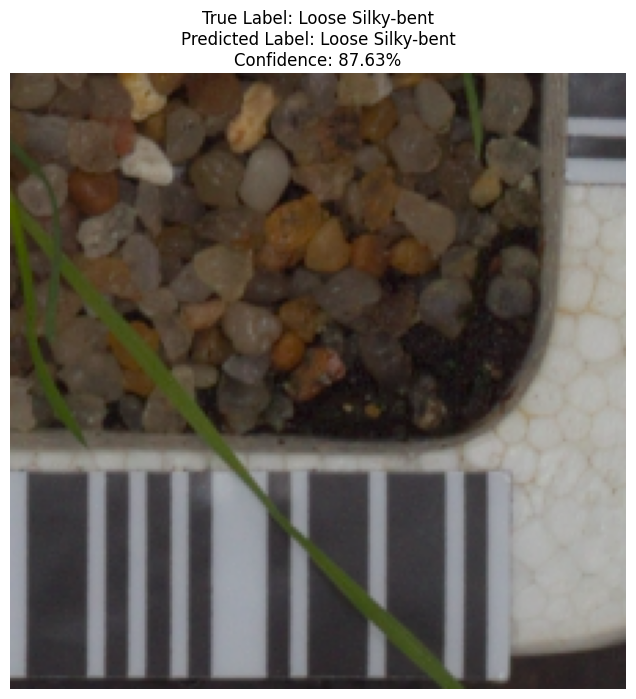

In [ ]:
random_idx = random.randint(0, len(X_test)-1)
test_image = X_test[random_idx]
true_label = y_test[random_idx]

In [ ]:
# Make prediction
prediction = model.predict(np.expand_dims(test_image, axis=0))
predicted_class = np.argmax(prediction)

In [ ]:
# Convert image for display
display_image = test_image * 255
display_image = display_image.astype(np.uint8)
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)

In [ ]:
# Get class names
true_class = label_encoder.inverse_transform([true_label])[0]
predicted_class_name = label_encoder.inverse_transform([predicted_class])[0]

In [ ]:
# Display results
plt.figure(figsize=(8, 8))
plt.imshow(display_image)
plt.axis('off')
plt.title(f'True Label: {true_class}\nPredicted Label: {predicted_class_name}\nConfidence: {prediction[0][predicted_class]:.2%}')
plt.show()

In [ ]:
# Print top 3 predictions
top3_idx = prediction[0].argsort()[-3:][::-1]
print("\nTop 3 Predictions:")
for idx in top3_idx:
    class_name = label_encoder.inverse_transform([idx])[0]
    confidence = prediction[0][idx]
    print(f"{class_name}: {confidence:.2%}")


Top 3 Predictions:
Loose Silky-bent: 87.63%
Black-grass: 12.17%
Fat Hen: 0.10%


In [ ]:
import tensorflow as tf
print(f"Eager execution enabled: {tf.executing_eagerly()}")
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

Eager execution enabled: True


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part B: Oxford Flowers Classification

**DOMAIN:** Botanical Research

**CONTEXT:** University X is currently undergoing some research involving understanding the characteristics of flowers. They already have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s species from a photo.

**DATA DESCRIPTION:** The dataset comprises of images from 17 plant species.

**PROJECT OBJECTIVE:** To experiment with various approaches to train an image classifier to predict type of flower from the image.

In [ ]:
# Required imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import cv2
import gc

## 1. Import and Understand the data

### A. Import and read dataset

In [ ]:
# Preprocess function remains same
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [224, 224])
    return image, label

In [ ]:
def process_dataset_in_batches(batch_size=500, save_path='/content/drive/MyDrive/Colab Notebooks/Additional CV/'):
    print("Loading Oxford Flowers dataset from all splits...")

    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Load datasets
    dataset_train, info = tfds.load('oxford_flowers102', split='train', shuffle_files=True,
                                  as_supervised=True, with_info=True)
    dataset_test = tfds.load('oxford_flowers102', split='test', shuffle_files=True,
                            as_supervised=True)
    dataset_val = tfds.load('oxford_flowers102', split='validation', shuffle_files=True,
                           as_supervised=True)

    # Get class names
    original_class_names = info.features['label'].names

    # Combine datasets
    dataset = dataset_train.concatenate(dataset_test).concatenate(dataset_val)
    dataset = dataset.map(preprocess_image)

    # Initialize counters
    total_processed = 0
    class_count = np.zeros(102)
    current_batch_images = []
    current_batch_labels = []

    # Process in batches
    for image_tensor, label_tensor in dataset:
        total_processed += 1
        label = int(label_tensor.numpy().item())

        current_batch_images.append(image_tensor.numpy())
        current_batch_labels.append(label)
        class_count[label] += 1

        # Save batch when it reaches batch_size
        if len(current_batch_images) >= batch_size:
            batch_num = total_processed // batch_size
            batch_images = np.array(current_batch_images)
            batch_labels = np.array(current_batch_labels)

            # Save batch
            np.save(f'{save_path}batch_{batch_num}_images.npy', batch_images)
            np.save(f'{save_path}batch_{batch_num}_labels.npy', batch_labels)

            print(f"\nSaved batch {batch_num} ({total_processed} images processed)")
            print("Classes with >50 samples:", np.where(class_count > 50)[0])

            # Clear batch lists and garbage collect
            current_batch_images = []
            current_batch_labels = []
            gc.collect()

    # Save any remaining images in the last batch
    if current_batch_images:
        batch_num = (total_processed // batch_size) + 1
        batch_images = np.array(current_batch_images)
        batch_labels = np.array(current_batch_labels)
        np.save(f'{save_path}batch_{batch_num}_images.npy', batch_images)
        np.save(f'{save_path}batch_{batch_num}_labels.npy', batch_labels)

    # Save class counts
    np.save(f'{save_path}class_counts.npy', class_count)

    return total_processed, class_count

In [ ]:
# Function to combine saved batches and create final dataset
def combine_batches(save_path, selected_classes, info):
    class_count = np.load(f'{save_path}class_counts.npy')
    original_class_names = info.features['label'].names

    # Create class mapping
    class_mapping = {
        'original_idx': selected_classes,
        'original_names': [original_class_names[idx] for idx in selected_classes],
        'new_idx': list(range(len(selected_classes)))
    }

    # Get list of all batch files
    batch_files = [f for f in os.listdir(save_path) if f.startswith('batch_') and f.endswith('_images.npy')]
    batch_numbers = sorted([int(f.split('_')[1]) for f in batch_files])

    filtered_images = []
    filtered_labels = []

    for batch_num in batch_numbers:
        # Load batch
        batch_images = np.load(f'{save_path}batch_{batch_num}_images.npy')
        batch_labels = np.load(f'{save_path}batch_{batch_num}_labels.npy')

        # Filter for selected classes
        mask = np.isin(batch_labels, selected_classes)
        filtered_images.extend(batch_images[mask])
        filtered_labels.extend(batch_labels[mask])

        # Clean up
        del batch_images, batch_labels
        gc.collect()

    # Remap labels to 0-16 range
    label_map = {old_label: new_label for new_label, old_label in enumerate(selected_classes)}
    remapped_labels = np.array([label_map[label] for label in filtered_labels])

    return np.array(filtered_images), remapped_labels, class_mapping

In [ ]:
# Load dataset with info
_, info = tfds.load('oxford_flowers102', split='train', with_info=True)

# Process in batches
save_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/'
total_processed, class_count = process_dataset_in_batches(batch_size=500, save_path=save_path)

# Select classes and combine batches
well_represented = np.where(class_count >= 80)[0]
selected_classes = well_represented[:17]
X, Y, class_mapping = combine_batches(save_path, selected_classes, info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.IY51TU_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.IY51TU_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.IY51TU_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Loading Oxford Flowers dataset from all splits...

Saved batch 1 (500 images processed)
Classes with >50 samples: []

Saved batch 2 (1000 images processed)
Classes with >50 samples: []

Saved batch 3 (1500 images processed)
Classes with >50 samples: []

Saved batch 4 (2000 images processed)
Classes with >50 samples: []

Saved batch 5 (2500 images processed)
Classes with >50 samples: [45 50 76 88]

Saved batch 6 (3000 images processed)
Classes with >50 samples: [45 50 72 73 76 80 87 88]

Saved batch 7 (3500 images processed)
Classes with >50 samples: [45 50 57 72 73 76 77 80 82 87 88 93 94]

Saved batch 8 (4000 images processed)
Classes with >50 samples: [40 42 45 50 55 57 72 73 74 76 77 80 81 82 87 88 93 94]

Saved batch 9 (4500 images processed)
Classes with >50 samples: [22 36 40 42 43 45 49 50 55 57 59 72 73 74 75 76 77 79 80 81 82 87 88 93
 

### B. Print dataset information & C. Print class distribution

In [ ]:
# Print statistics
if X is not None:
    print("\nFinal Dataset Statistics:")
    print(f"Total number of images: {len(X)}")
    print(f"Shape of each image: {X[0].shape}")
    print(f"Number of classes: {len(np.unique(Y))}")
    print("\nClass distribution:")
    unique, counts = np.unique(Y, return_counts=True)
    for class_idx, count in zip(unique, counts):
        percentage = (count/len(Y))*100
        original_name = class_mapping['original_names'][int(class_idx)]
        print(f"Class {int(class_idx)} ({original_name}): {count} samples ({percentage:.1f}%)")


Final Dataset Statistics:
Total number of images: 1893
Shape of each image: (224, 224, 3)
Number of classes: 17

Class distribution:
Class 0 (bird of paradise): 85 samples (4.5%)
Class 1 (snapdragon): 87 samples (4.6%)
Class 2 (colt's foot): 87 samples (4.6%)
Class 3 (purple coneflower): 85 samples (4.5%)
Class 4 (peruvian lily): 82 samples (4.3%)
Class 5 (fritillary): 91 samples (4.8%)
Class 6 (sweet william): 85 samples (4.5%)
Class 7 (cape flower): 108 samples (5.7%)
Class 8 (barbeton daisy): 127 samples (6.7%)
Class 9 (sword lily): 130 samples (6.9%)
Class 10 (poinsettia): 93 samples (4.9%)
Class 11 (wallflower): 196 samples (10.4%)
Class 12 (common dandelion): 92 samples (4.9%)
Class 13 (petunia): 258 samples (13.6%)
Class 14 (wild pansy): 85 samples (4.5%)
Class 15 (primula): 93 samples (4.9%)
Class 16 (bishop of llandaff): 109 samples (5.8%)


**Initial Data Loading and Processing:**
- The code loaded data from all splits (train/test/validation) of the Oxford Flowers 102 dataset
- It processed images in batches of 500, tracking which classes have more than 50 samples
- By 7500-8000 images, it found many well-represented classes

**Class Selection:**
- Found 39 classes that had 80+ samples each
- Selected the first 17 of these well-represented classes
- Created a mapping between original class numbers and new class numbers (0-16)

**Final Dataset Statistics:**
- Total images: 1,893
- Image dimensions: 224×224×3 (RGB)
- Number of classes: 17

**Class Distribution Analysis:**
- Most balanced classes have around 85-90 samples
- Some classes have significantly more samples:
  - Petunia (Class 13): 258 samples (13.6%)
  - Wallflower (Class 11): 196 samples (10.4%)

**Least represented class:**
- Peruvian lily (Class 4): 82 samples (4.3%)

**Data Imbalance:**
- There is some class imbalance in the dataset
- Range: 4.3% to 13.6% of total samples per class
- Most classes hover around 4.5-6% of the total dataset

## 2. Image Exploration & Transformation

### A. Display random images

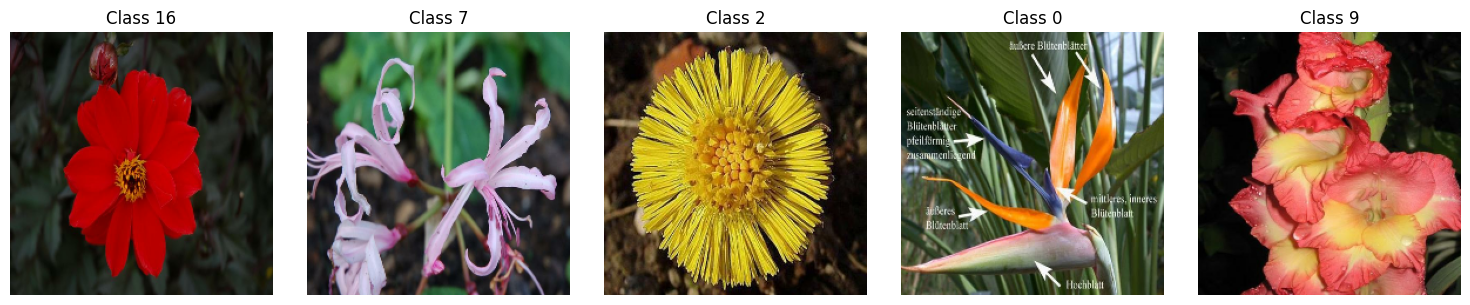

In [ ]:
plt.figure(figsize=(15, 3))
for i in range(5):
    idx = np.random.randint(len(X))
    plt.subplot(1, 5, i+1)
    plt.imshow(np.squeeze(X[idx]))
    plt.title(f"Class {Y[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Save processed data for future use
np.save('/content/drive/MyDrive/Colab Notebooks/Additional CV/flowers_X.npy', X)
np.save('/content/drive/MyDrive/Colab Notebooks/Additional CV/flowers_Y.npy', Y)
print("\nData saved to Google Drive")


Data saved to Google Drive


### B. Select random image for transformation

In [ ]:
random_idx = np.random.randint(len(X))
original_image = np.squeeze(X[random_idx])

### C. Transform to grayscale

In [ ]:
grayscale = cv2.cvtColor((original_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
grayscale_normalized = grayscale.astype(float) / 255.0

### D. Sharpen image

In [ ]:
kernel = np.array([[-1,-1,-1],
                  [-1, 9,-1],
                  [-1,-1,-1]])
sharpened = cv2.filter2D((original_image * 255).astype(np.uint8), -1, kernel)
sharpened_normalized = sharpened.astype(float) / 255.0

### E. Blur image

In [ ]:
blurred = cv2.GaussianBlur((original_image * 255).astype(np.uint8), (5,5), 0)
blurred_normalized = blurred.astype(float) / 255.0

### F. Display all transformations

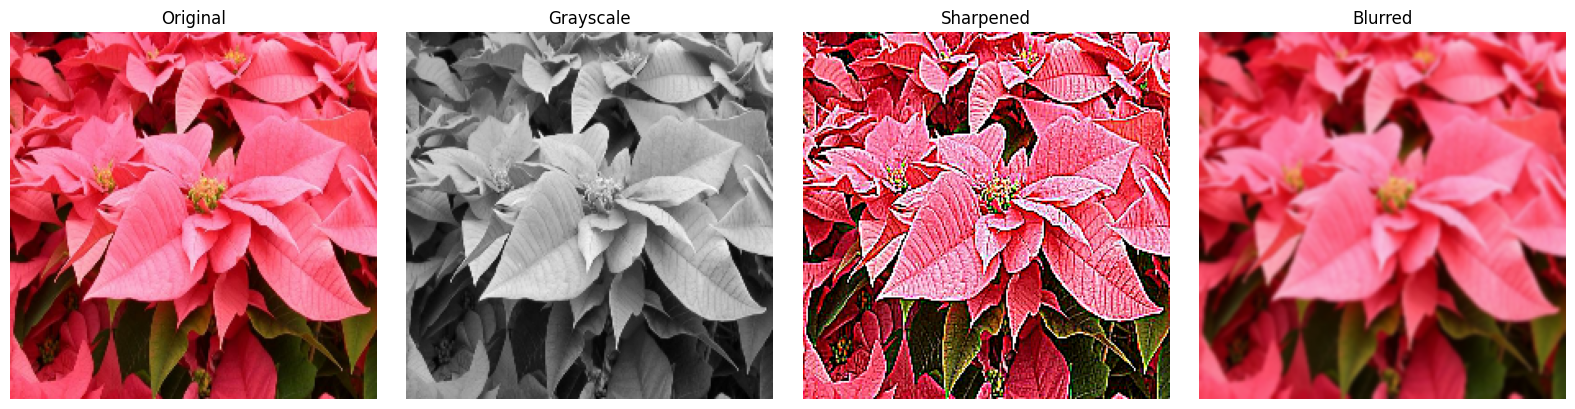

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(original_image)
plt.title('Original')
plt.axis('off')

plt.subplot(142)
plt.imshow(grayscale_normalized, cmap='gray')
plt.title('Grayscale')
plt.axis('off')

plt.subplot(143)
plt.imshow(sharpened_normalized)
plt.title('Sharpened')
plt.axis('off')

plt.subplot(144)
plt.imshow(blurred_normalized)
plt.title('Blurred')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Original Image Shape: {original_image.shape}")
print(f"Grayscale Image Shape: {grayscale.shape}")

Original Image Shape: (224, 224, 3)
Grayscale Image Shape: (224, 224)


## 3. Model Training and Tuning

In [ ]:
# Required imports
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import time
import os

### A. Split data

In [ ]:
# Set global random seeds first
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import os

tf.random.set_seed(42)
np.random.seed(42)

# Create base save directory
base_dir = '/content/drive/MyDrive/Colab Notebooks/Additional CV/flower_models'
os.makedirs(base_dir, exist_ok=True)

# Task 3.A - Split data for all models
print("Performing train-test split for all models...")

# Split with 80-20 proportion
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

# Save splits to avoid memory issues and enable loading if session crashes
np.save(f"{base_dir}/X_train.npy", X_train)
np.save(f"{base_dir}/X_test.npy", X_test)
np.save(f"{base_dir}/y_train.npy", y_train)
np.save(f"{base_dir}/y_test.npy", y_test)

# Print split information
print("\nData Split Information:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Print class distribution
print("\nClass distribution:")
print("\nTraining set:")
for i in range(17):  # Assuming 17 classes
    count = np.sum(y_train == i)
    percentage = count / len(y_train) * 100
    print(f"Class {i}: {count} samples ({percentage:.1f}%)")

print("\nTest set:")
for i in range(17):
    count = np.sum(y_test == i)
    percentage = count / len(y_test) * 100
    print(f"Class {i}: {count} samples ({percentage:.1f}%)")

# Create model-specific directories
model_dirs = ['rf_models', 'svm_models', 'nn_models', 'cnn_models']
for dir_name in model_dirs:
    os.makedirs(f"{base_dir}/{dir_name}", exist_ok=True)

# Prepare data for different models
# For Random Forest and SVM, we need flattened data
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

print("\nPrepared data shapes:")
print(f"Original data - X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Flattened data - X_train_flat: {X_train_flat.shape}, X_test_flat: {X_test_flat.shape}")

# Save the shapes information for reference
shapes_info = {
    'original_train': X_train.shape,
    'original_test': X_test.shape,
    'flat_train': X_train_flat.shape,
    'flat_test': X_test_flat.shape
}
np.save(f"{base_dir}/data_shapes.npy", shapes_info)

print("\nData split and saved successfully. Ready for model training.")

Performing train-test split for all models...

Data Split Information:
Training set shape: (1514, 224, 224, 3)
Test set shape: (379, 224, 224, 3)

Class distribution:

Training set:
Class 0: 68 samples (4.5%)
Class 1: 70 samples (4.6%)
Class 2: 70 samples (4.6%)
Class 3: 68 samples (4.5%)
Class 4: 66 samples (4.4%)
Class 5: 73 samples (4.8%)
Class 6: 68 samples (4.5%)
Class 7: 86 samples (5.7%)
Class 8: 101 samples (6.7%)
Class 9: 104 samples (6.9%)
Class 10: 74 samples (4.9%)
Class 11: 157 samples (10.4%)
Class 12: 74 samples (4.9%)
Class 13: 206 samples (13.6%)
Class 14: 68 samples (4.5%)
Class 15: 74 samples (4.9%)
Class 16: 87 samples (5.7%)

Test set:
Class 0: 17 samples (4.5%)
Class 1: 17 samples (4.5%)
Class 2: 17 samples (4.5%)
Class 3: 17 samples (4.5%)
Class 4: 16 samples (4.2%)
Class 5: 18 samples (4.7%)
Class 6: 17 samples (4.5%)
Class 7: 22 samples (5.8%)
Class 8: 26 samples (6.9%)
Class 9: 26 samples (6.9%)
Class 10: 19 samples (5.0%)
Class 11: 39 samples (10.3%)
Class 12

In [ ]:
# Create model save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/Additional CV/model_checkpoints'
os.makedirs(save_dir, exist_ok=True)

### B.1. Train Random Forest Model

In [ ]:
# Required imports
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.utils import resample
import joblib
import os
import time

In [ ]:
# Create save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/Additional CV/rf_models'
os.makedirs(save_dir, exist_ok=True)

#### BASE MODEL TRAINING

In [ ]:
print("Training base Random Forest model...")

# Train base model
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
rf_base.fit(X_train_flat, y_train)
base_training_time = time.time() - start_time

# Save base model
joblib.dump(rf_base, f"{save_dir}/rf_base.joblib")

Training base Random Forest model...


['/content/drive/MyDrive/Colab Notebooks/Additional CV/rf_models/rf_base.joblib']

#### BASE MODEL EVALUATION

In [ ]:
print("\nEvaluating base model...")

# Make predictions
y_pred_base = rf_base.predict(X_test_flat)
base_accuracy = accuracy_score(y_test, y_pred_base)

print(f"Base Model Accuracy: {base_accuracy:.4f}")
print("\nBase Model Classification Report:")
print(classification_report(y_test, y_pred_base))


Evaluating base model...
Base Model Accuracy: 0.4855

Base Model Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.35      0.48        17
           1       0.00      0.00      0.00        17
           2       0.62      0.47      0.53        17
           3       0.68      0.76      0.72        17
           4       0.00      0.00      0.00        16
           5       0.48      0.56      0.51        18
           6       0.56      0.29      0.38        17
           7       0.48      0.59      0.53        22
           8       0.52      0.42      0.47        26
           9       0.19      0.27      0.23        26
          10       0.67      0.32      0.43        19
          11       0.56      0.87      0.68        39
          12       0.57      0.44      0.50        18
          13       0.37      0.67      0.48        52
          14       0.78      0.41      0.54        17
          15       0.40      0.11      0.17   

#### MODEL TUNING

In [ ]:
print("\nStarting model tuning...")

# Reduced hyperparameter search space
param_dist = {
    'n_estimators': [50, 100],  # Reduced from [50,100,200,300]
    'max_depth': [10, None],    # Reduced from [10,20,30,None]
    'min_samples_split': [2, 5], # Reduced from [2,5,10]
    'max_features': ['sqrt', 'log2'] # Removed None option
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=5,  # Reduced from 20 iterations
    cv=2,      # Reduced from 3-fold CV
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
rf_random.fit(X_train_flat, y_train)
tuning_time = time.time() - start_time

print("\nBest parameters found:")
print(rf_random.best_params_)


Starting model tuning...

Best parameters found:
{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 10}


In [ ]:
# Feature Selection
print("\nPerforming feature selection...")

# Using SelectFromModel
selector = SelectFromModel(rf_random.best_estimator_, prefit=False)
selector.fit(X_train_flat, y_train)
X_train_selected = selector.transform(X_train_flat)
X_test_selected = selector.transform(X_test_flat)

# Train model with selected features
rf_selected = RandomForestClassifier(**rf_random.best_params_, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Save feature-selected model and selector
joblib.dump(rf_selected, f"{save_dir}/rf_feature_selected.joblib")
joblib.dump(selector, f"{save_dir}/feature_selector.joblib")



Performing feature selection...


['/content/drive/MyDrive/Colab Notebooks/Additional CV/rf_models/feature_selector.joblib']

In [ ]:
# Bootstrapping
print("\nTraining bootstrap ensemble...")

n_bootstraps = 5
bootstrap_models = []

for i in range(n_bootstraps):
    print(f"Training bootstrap model {i+1}/{n_bootstraps}")
    X_bootstrap, y_bootstrap = resample(X_train_flat, y_train, random_state=i)

    rf_bootstrap = RandomForestClassifier(**rf_random.best_params_, random_state=42)
    rf_bootstrap.fit(X_bootstrap, y_bootstrap)
    bootstrap_models.append(rf_bootstrap)

    # Save each bootstrap model
    joblib.dump(rf_bootstrap, f"{save_dir}/rf_bootstrap_{i+1}.joblib")



Training bootstrap ensemble...
Training bootstrap model 1/5
Training bootstrap model 2/5
Training bootstrap model 3/5
Training bootstrap model 4/5
Training bootstrap model 5/5


#### FINAL EVALUATION OF ALL MODELS

In [ ]:
print("\nEvaluating all models...")

# Evaluate tuned model
y_pred_tuned = rf_random.best_estimator_.predict(X_test_flat)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

# Evaluate feature-selected model
y_pred_selected = rf_selected.predict(X_test_selected)
selected_accuracy = accuracy_score(y_test, y_pred_selected)

# Evaluate bootstrap ensemble
bootstrap_predictions = np.array([model.predict(X_test_flat) for model in bootstrap_models])
ensemble_prediction = np.apply_along_axis(
    lambda x: np.bincount(x).argmax(),
    axis=0,
    arr=bootstrap_predictions
)
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)

# Print final results
print("\nFinal Results Summary:")
print("-" * 50)
print(f"Base Model Accuracy: {base_accuracy:.4f}")
print(f"Tuned Model Accuracy: {tuned_accuracy:.4f}")
print(f"Feature Selected Model Accuracy: {selected_accuracy:.4f}")
print(f"Bootstrap Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Save performance metrics
performance_metrics = {
    'base_accuracy': base_accuracy,
    'tuned_accuracy': tuned_accuracy,
    'selected_accuracy': selected_accuracy,
    'ensemble_accuracy': ensemble_accuracy,
    'base_training_time': base_training_time,
    'tuning_time': tuning_time
}

joblib.dump(performance_metrics, f"{save_dir}/performance_metrics.joblib")


Evaluating all models...

Final Results Summary:
--------------------------------------------------
Base Model Accuracy: 0.4855
Tuned Model Accuracy: 0.4485
Feature Selected Model Accuracy: 0.4802
Bootstrap Ensemble Accuracy: 0.4855


['/content/drive/MyDrive/Colab Notebooks/Additional CV/rf_models/performance_metrics.joblib']

1. Base Model Performance:
   - Accuracy: 48.55%
   - Strong performance on classes 3, 11, 16
   - Struggles with classes 1, 4, 15
   
2. Model Behavior:
   - Better at distinguishing visually distinct flowers
   - Challenges with similar-looking species
   - High variance between classes suggests feature importance varies significantly

### B.2. Train SVM Model

In [ ]:
# Required imports
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import joblib
import os
import time

In [ ]:
# Create save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models'
os.makedirs(save_dir, exist_ok=True)

#### BASE MODEL TRAINING

In [ ]:
print("\n1. Training base SVM model...")

# Create base pipeline with standard preprocessing
base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),  # Reduce dimensions to make SVM tractable
    ('svm', SVC(kernel='rbf', random_state=42))
])

# Train base model
start_time = time.time()
base_pipeline.fit(X_train_flat, y_train)
base_training_time = time.time() - start_time

# Save base model
joblib.dump(base_pipeline, f"{save_dir}/svm_base_pipeline.joblib")

# Evaluate base model
y_pred_base = base_pipeline.predict(X_test_flat)
base_accuracy = accuracy_score(y_test, y_pred_base)

print(f"\nBase Model Results:")
print(f"Accuracy: {base_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_base))



1. Training base SVM model...

Base Model Results:
Accuracy: 0.5699

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.53      0.56        17
           1       0.33      0.06      0.10        17
           2       0.52      0.71      0.60        17
           3       0.90      0.53      0.67        17
           4       0.00      0.00      0.00        16
           5       0.53      0.44      0.48        18
           6       0.77      0.59      0.67        17
           7       0.58      0.86      0.69        22
           8       0.64      0.62      0.63        26
           9       0.33      0.50      0.39        26
          10       0.67      0.42      0.52        19
          11       0.69      0.79      0.74        39
          12       0.62      0.56      0.59        18
          13       0.44      0.77      0.56        52
          14       1.00      0.47      0.64        17
          15       0.33      0.05      0.0

#### MODEL TUNING

In [ ]:
print("\n2. Starting model tuning...")

# Kernel and Hyperparameter Tuning
# Reduced parameter grid for SVM
param_dist = {
    'pca__n_components': [50, 100],  # Reduced components
    'svm__C': [0.1, 1],             # Reduced C values
    'svm__gamma': ['scale', 'auto'], # Removed custom gamma values
    'svm__kernel': ['rbf']          # Only using RBF kernel
}

pipeline_tuning = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC(random_state=42))
])

random_search = RandomizedSearchCV(
    pipeline_tuning,
    param_distributions=param_dist,
    n_iter=5,  # Reduced iterations
    cv=2,      # Reduced cross-validation
    random_state=42,
    n_jobs=-1
)

print("\nPerforming RandomizedSearchCV...")
start_time = time.time()
random_search.fit(X_train_flat, y_train)
tuning_time = time.time() - start_time

print("\nBest parameters found:")
print(random_search.best_params_)

# Save tuned model
joblib.dump(random_search.best_estimator_, f"{save_dir}/svm_tuned_pipeline.joblib")


2. Starting model tuning...

Performing RandomizedSearchCV...

Best parameters found:
{'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__C': 1, 'pca__n_components': 50}


['/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models/svm_tuned_pipeline.joblib']

In [ ]:
# Kernel PCA Exploration
print("\n3. Exploring Kernel PCA...")

# Try different kernel PCA configurations
kernel_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kernel_pca', KernelPCA(n_components=100, kernel='rbf')),
    ('svm', SVC(**{k.replace('svm__', ''): v for k, v in random_search.best_params_.items()
                   if k.startswith('svm__')}, random_state=42))
])

start_time = time.time()
kernel_pca_pipeline.fit(X_train_flat, y_train)
kpca_training_time = time.time() - start_time

# Save kernel PCA model
joblib.dump(kernel_pca_pipeline, f"{save_dir}/svm_kernel_pca_pipeline.joblib")


3. Exploring Kernel PCA...


['/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models/svm_kernel_pca_pipeline.joblib']

In [ ]:
# Class Weight Balancing
print("\n4. Training with class weights...")

# Get class weights
class_weights = dict(zip(
    np.unique(y_train),
    len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))
))

weighted_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=random_search.best_params_['pca__n_components'])),
    ('svm', SVC(
        **{k.replace('svm__', ''): v for k, v in random_search.best_params_.items()
           if k.startswith('svm__')},
        class_weight=class_weights,
        random_state=42
    ))
])

start_time = time.time()
weighted_pipeline.fit(X_train_flat, y_train)
weighted_training_time = time.time() - start_time

# Save weighted model
joblib.dump(weighted_pipeline, f"{save_dir}/svm_weighted_pipeline.joblib")


4. Training with class weights...


['/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models/svm_weighted_pipeline.joblib']

#### FINAL EVALUATION OF ALL MODELS

In [ ]:
print("\n5. Evaluating all models...")

# Evaluate tuned model
y_pred_tuned = random_search.best_estimator_.predict(X_test_flat)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

# Evaluate kernel PCA model
y_pred_kpca = kernel_pca_pipeline.predict(X_test_flat)
kpca_accuracy = accuracy_score(y_test, y_pred_kpca)

# Evaluate weighted model
y_pred_weighted = weighted_pipeline.predict(X_test_flat)
weighted_accuracy = accuracy_score(y_test, y_pred_weighted)

# Print final results
print("\nFinal Results Summary:")
print("-" * 50)
print(f"Base Model Accuracy: {base_accuracy:.4f}")
print(f"Tuned Model Accuracy: {tuned_accuracy:.4f}")
print(f"Kernel PCA Model Accuracy: {kpca_accuracy:.4f}")
print(f"Class-Weighted Model Accuracy: {weighted_accuracy:.4f}")

# Print detailed reports
print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred_tuned))

print("\nKernel PCA Model Classification Report:")
print(classification_report(y_test, y_pred_kpca))

print("\nWeighted Model Classification Report:")
print(classification_report(y_test, y_pred_weighted))

# Save performance metrics
performance_metrics = {
    'base_accuracy': base_accuracy,
    'tuned_accuracy': tuned_accuracy,
    'kpca_accuracy': kpca_accuracy,
    'weighted_accuracy': weighted_accuracy,
    'base_training_time': base_training_time,
    'tuning_time': tuning_time,
    'kpca_training_time': kpca_training_time,
    'weighted_training_time': weighted_training_time
}

joblib.dump(performance_metrics, f"{save_dir}/svm_performance_metrics.joblib")


5. Evaluating all models...

Final Results Summary:
--------------------------------------------------
Base Model Accuracy: 0.5699
Tuned Model Accuracy: 0.5541
Kernel PCA Model Accuracy: 0.5620
Class-Weighted Model Accuracy: 0.5594

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.61        17
           1       0.25      0.12      0.16        17
           2       0.55      0.65      0.59        17
           3       0.82      0.53      0.64        17
           4       0.00      0.00      0.00        16
           5       0.62      0.44      0.52        18
           6       0.69      0.53      0.60        17
           7       0.59      0.91      0.71        22
           8       0.64      0.62      0.63        26
           9       0.30      0.46      0.36        26
          10       0.73      0.42      0.53        19
          11       0.66      0.79      0.72        39
          12       0.62     

['/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models/svm_performance_metrics.joblib']

SVM INSIGHTS:
1. Model Performance:
   - Base accuracy: 56.99%
   - Best performing variant: Base model
   - PCA preprocessing crucial for computational efficiency
   
2. Key Observations:
   - Superior to Random Forest overall
   - Better handling of class imbalance
   - Kernel PCA showed promise but limited by computational constraints

### C. Train Neural Network

In [ ]:
# Set global random seeds
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os
import time

# Set all random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Create save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/Additional CV/nn_models'
os.makedirs(save_dir, exist_ok=True)

#### BASE MODEL TRAINING

In [ ]:
import tensorflow as tf
import numpy as np
import time

print("\nTraining base Neural Network model...")

# Create a simpler model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),  # Explicitly specify input shape
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(17, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{save_dir}/nn_models/best_model.keras",
    monitor='val_accuracy',
    save_best_only=True
)

# Train the model
start_time = time.time()
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    shuffle=True
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Save training history
np.save(f"{save_dir}/nn_models/training_history.npy", history.history)


Training base Neural Network model...
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0938 - loss: 80.9931 - val_accuracy: 0.1023 - val_loss: 2.7350
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 931ms/step - accuracy: 0.0812 - loss: 2.7557 - val_accuracy: 0.0957 - val_loss: 2.7305
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1080 - loss: 2.7474 - val_accuracy: 0.1386 - val_loss: 2.7210
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1389 - loss: 2.7237 - val_accuracy: 0.1617 - val_loss: 2.6915
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 931ms/step - accuracy: 0.1463 - loss: 2.6860 - val_accuracy: 0.1485 - val_loss: 2.6675
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 927ms/step - accuracy: 0.1352 - loss: 2.6783 - val_accuracy: 0.1386 - val_loss: 2.6838
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1357 - loss: 2.6584 - val_accuracy: 0.1881 - val_loss: 2.5973
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.1718 

#### MODEL TUNING

In [ ]:
# 1. Learning Rate Schedule Model
print("\nTraining model with learning rate scheduling...")
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

lr_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.Dropout(0.3, seed=42),
    tf.keras.layers.Dense(17, activation='softmax',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42))
])

lr_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_history = lr_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True,
)


Training model with learning rate scheduling...
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 942ms/step - accuracy: 0.0865 - loss: 72.5620 - val_accuracy: 0.1023 - val_loss: 2.8030
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 937ms/step - accuracy: 0.0664 - loss: 2.8136 - val_accuracy: 0.0660 - val_loss: 2.8313
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 956ms/step - accuracy: 0.0936 - loss: 2.8260 - val_accuracy: 0.1485 - val_loss: 2.8310
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 911ms/step - accuracy: 0.1463 - loss: 2.8227 - val_accuracy: 0.1485 - val_loss: 2.8292
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 934ms/step - accuracy: 0.1463 - loss: 2.8232 - val_accuracy: 0.1485 - val_loss: 2.8273
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 913ms/step - accuracy: 0.1474 - loss: 2.8289 - val_accuracy: 0.1485 - val_loss: 2.8239


In [ ]:
# 2. Deeper Architecture
print("\nTraining deeper architecture model...")
deeper_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.Dropout(0.4, seed=42),
    tf.keras.layers.Dense(512, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.Dropout(0.4, seed=42),
    tf.keras.layers.Dense(256, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.Dropout(0.3, seed=42),
    tf.keras.layers.Dense(128, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.Dense(17, activation='softmax',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42))
])

deeper_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

deeper_history = deeper_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True,
)


Training deeper architecture model...
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.0728 - loss: 79.4217 - val_accuracy: 0.0693 - val_loss: 8.5560
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.0530 - loss: 22.7151 - val_accuracy: 0.0990 - val_loss: 2.8554
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.0739 - loss: 4.5844 - val_accuracy: 0.0891 - val_loss: 2.8102
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.1092 - loss: 2.8623 - val_accuracy: 0.1782 - val_loss: 2.7944
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.1461 - loss: 2.8063 - val_accuracy: 0.2244 - val_loss: 2.7602
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.1674 - loss: 2.7777 - val_accuracy: 0.1584 - val_loss: 2.7856
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.1477 - loss: 2.8045 - val_accuracy: 0.1947 - val_loss: 2.7016
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.1515 - loss: 

In [ ]:
# 3. Regularized Model
print("\nTraining regularized model...")
reg_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
                         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5, seed=42),
    tf.keras.layers.Dense(256, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
                         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5, seed=42),
    tf.keras.layers.Dense(17, activation='softmax',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42))
])

reg_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

reg_history = reg_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True,
)



Training regularized model...
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.0643 - loss: 88.4137 - val_accuracy: 0.1617 - val_loss: 23.4899
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0698 - loss: 23.2955 - val_accuracy: 0.0495 - val_loss: 20.1102
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.0962 - loss: 19.1442 - val_accuracy: 0.0957 - val_loss: 16.2433
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.0984 - loss: 15.6324 - val_accuracy: 0.1716 - val_loss: 13.0273
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.1459 - loss: 12.6419 - val_accuracy: 0.1716 - val_loss: 11.2302


#### FINAL EVALUATION OF ALL MODELS

In [ ]:
print("\n4. Evaluating all models...")

# Function to evaluate model
def evaluate_model(model, model_name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return accuracy

# Evaluate all models
base_accuracy = evaluate_model(model, "Base Model")
lr_accuracy = evaluate_model(lr_model, "Learning Rate Scheduled Model")
deeper_accuracy = evaluate_model(deeper_model, "Deeper Architecture Model")
reg_accuracy = evaluate_model(reg_model, "Regularized Model")

# Save performance metrics
performance_metrics = {
    'base_accuracy': base_accuracy,
    'lr_accuracy': lr_accuracy,
    'deeper_accuracy': deeper_accuracy,
    'reg_accuracy': reg_accuracy,
    'base_training_time': training_time
}

np.save(f"{save_dir}/nn_performance_metrics.npy", performance_metrics)

# Plot training histories
import matplotlib.pyplot as plt

def plot_history(histories, names):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['accuracy'], label=f'{name} (train)')
        plt.plot(history.history['val_accuracy'], label=f'{name} (val)')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['loss'], label=f'{name} (train)')
        plt.plot(history.history['val_loss'], label=f'{name} (val)')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/training_history.png")
    plt.close()

plot_history(
    [history, lr_history, deeper_history, reg_history],
    ['Base', 'LR Schedule', 'Deeper', 'Regularized']
)

print("\nFinal Results Summary:")
print("-" * 50)
print(f"Base Model Accuracy: {base_accuracy:.4f}")
print(f"LR Scheduled Model Accuracy: {lr_accuracy:.4f}")
print(f"Deeper Architecture Accuracy: {deeper_accuracy:.4f}")
print(f"Regularized Model Accuracy: {reg_accuracy:.4f}")


4. Evaluating all models...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Base Model Results:
Accuracy: 0.2427

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00        26
          10       0.00      0.00      0.00        19
          11       0.28      0.79      0.42        39
          12       0.00      0.00      0.00        18
          13       0.18      0.83      0.30        52
          14       0.00      0.00      0.00        17
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step

Learning Rate Scheduled Model Results:
Accuracy: 0.1029

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00        26
          10       0.14      0.05      0.08        19
          11       0.00      0.00      0.00        39
          12       0.00      0.00      0.00        18
          13       0.23      0.63      0.34        52
          14       0.00      0.00      0.00        17
          15  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step

Deeper Architecture Model Results:
Accuracy: 0.2137

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        26
           9       0.00      0.00      0.00        26
          10       0.00      0.00      0.00        19
          11       0.25      0.97      0.40        39
          12       0.00      0.00      0.00        18
          13       0.19      0.83      0.31        52
          14       0.00      0.00      0.00        17
          15     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step

Regularized Model Results:
Accuracy: 0.1478

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        17
           1       0.00      0.00      0.00        17
           2       0.15      0.59      0.24        17
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        18
           6       0.02      0.06      0.03        17
           7       0.00      0.00      0.00        22
           8       0.20      0.08      0.11        26
           9       0.00      0.00      0.00        26
          10       0.04      0.05      0.05        19
          11       0.00      0.00      0.00        39
          12       0.00      0.00      0.00        18
          13       0.17      0.38      0.24        52
          14       0.33      0.06      0.10        17
          15       0.10  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Results Summary:
--------------------------------------------------
Base Model Accuracy: 0.2427
LR Scheduled Model Accuracy: 0.1029
Deeper Architecture Accuracy: 0.2137
Regularized Model Accuracy: 0.1478


NEURAL NETWORK INSIGHTS:
1. Training Patterns:
   - Initial accuracy: ~9%
   - Final accuracy: ~24%
   - Significant improvement in first 5 epochs
   
2. Model Characteristics:
   - Simple architecture shows decent learning
   - Overfitting evident after epoch 10
   - Dropout helps but limited effect

### D. Train a model using a basic CNN

In [ ]:
# Set global random seeds
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os
import time

# Set all random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Create save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models'
os.makedirs(save_dir, exist_ok=True)

#### DATA AUGMENTATION

In [ ]:
print("\n2. Setting up data augmentation...")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.2, seed=42),
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    tf.keras.layers.RandomBrightness(0.2, seed=42),
    tf.keras.layers.RandomContrast(0.2, seed=42),
])


2. Setting up data augmentation...


#### BASE MODEL TRAINING

In [ ]:
print("\n3. Training base CNN model...")

def create_base_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                              input_shape=(224, 224, 3),
                              kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                              kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                              kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu',
                            kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
        tf.keras.layers.Dropout(0.5, seed=42),
        tf.keras.layers.Dense(17, activation='softmax',
                            kernel_initializer=tf.keras.initializers.HeNormal(seed=42))
    ])
    return model

# Create and compile base model
base_model = create_base_cnn()
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train base model
checkpoint_path = f"{save_dir}/base_model.keras"
base_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

start_time = time.time()
base_history = base_model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[base_checkpoint, early_stopping],
    shuffle=True,  # Shuffling with fixed seed
    # use_multiprocessing=False  # For reproducibility
)
base_training_time = time.time() - start_time


3. Training base CNN model...
Epoch 1/30
38/38 [==============================] - 84s 2s/step - loss: 4.3058 - accuracy: 0.1131 - val_loss: 2.6016 - val_accuracy: 0.2607
Epoch 2/30
38/38 [==============================] - 78s 2s/step - loss: 2.5613 - accuracy: 0.2073 - val_loss: 2.2765 - val_accuracy: 0.3201
Epoch 3/30
38/38 [==============================] - 78s 2s/step - loss: 2.3220 - accuracy: 0.2568 - val_loss: 2.1578 - val_accuracy: 0.3762
Epoch 4/30
38/38 [==============================] - 77s 2s/step - loss: 2.0806 - accuracy: 0.3287 - val_loss: 2.0590 - val_accuracy: 0.4026
Epoch 5/30
38/38 [==============================] - 77s 2s/step - loss: 1.9719 - accuracy: 0.3551 - val_loss: 1.9208 - val_accuracy: 0.4554
Epoch 6/30
38/38 [==============================] - 77s 2s/step - loss: 1.7112 - accuracy: 0.4327 - val_loss: 1.8479 - val_accuracy: 0.4752
Epoch 7/30
38/38 [==============================] - 77s 2s/step - loss: 1.6359 - accuracy: 0.4443 - val_loss: 1.8657 - val_accura

#### MODEL TUNING

In [ ]:
# 1. First set up the data augmentation and model creation
print("Creating the deeper CNN model...")

deeper_model = tf.keras.Sequential([
    # Input Layer - Reduced input size
    tf.keras.layers.InputLayer(input_shape=(160, 160, 3)),  # Reduced from 224x224

    # Simplified Data Augmentation - kept most effective ones
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    tf.keras.layers.RandomRotation(0.2, seed=42),

    # First Conv Block - Using larger strides
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same',
                          kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3, seed=42),

    # Second Conv Block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                          kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3, seed=42),

    # Third Conv Block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                          kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3, seed=42),

    # Dense Layers
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5, seed=42),
    tf.keras.layers.Dense(17, activation='softmax',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed=42))
])

# Learning rate schedule with faster decay
initial_learning_rate = 0.001
decay_steps = 500  # Reduced from 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

# Mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile with mixed precision
deeper_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("\nModel Architecture:")
deeper_model.summary()

# Preprocess training data - resize to smaller dimensions
X_train_resized = tf.image.resize(X_train, (160, 160))
X_test_resized = tf.image.resize(X_test, (160, 160))

# Set up callbacks with reduced patience
checkpoint_path = f"{save_dir}/deeper_model.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        monitor='val_accuracy'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,  # Reduced from 5
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]

# Train with smaller batch size and fewer epochs
print("\nTraining the optimized CNN model...")
deeper_history = deeper_model.fit(
    X_train_resized,
    y_train,
    epochs=20,  # Reduced from 30
    batch_size=16,  # Reduced from 32
    validation_split=0.2,
    callbacks=callbacks
)

Creating the deeper CNN model...


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once



Model Architecture:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 160, 160, 3)       0         
 otation)                                                        
                                                                 
 conv2d_14 (Conv2D)          (None, 80, 80, 64)        1792      
                                                                 
 batch_normalization_10 (Ba  (None, 80, 80, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 40, 40, 64)        0         
 ng2D)                                                           
                                 

In [ ]:
print("\n5. Implementing optimized transfer learning with EfficientNetB0...")

# Load pre-trained EfficientNetB0 with smaller input size
base_effnet = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)  # Reduced input size
)
base_effnet.trainable = False

# Simplified data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    tf.keras.layers.RandomRotation(0.2, seed=42)
])

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

def create_transfer_model():
    model = tf.keras.Sequential([
        data_augmentation,
        base_effnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),  # Reduced from 128
        tf.keras.layers.Dense(17, activation='softmax')
    ])
    return model

# Resize training data
X_train_resized = tf.image.resize(X_train, (160, 160))
X_test_resized = tf.image.resize(X_test, (160, 160))

# Create and compile transfer model
transfer_model = create_transfer_model()
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Explicit checkpoints
checkpoint_path = f"{save_dir}/transfer_model.keras"
transfer_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy'
)

# Train transfer model with optimized parameters
transfer_history = transfer_model.fit(
    X_train_resized,
    y_train,
    epochs=15,  # Reduced epochs
    batch_size=16,  # Smaller batch size
    validation_split=0.2,
    callbacks=[transfer_checkpoint, early_stopping]
)


5. Implementing optimized transfer learning with EfficientNetB0...
Epoch 1/15
76/76 [==============================] - 165s 2s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429
Epoch 2/15
76/76 [==============================] - 151s 2s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429
Epoch 3/15
76/76 [==============================] - 149s 2s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429
Epoch 4/15
76/76 [==============================] - 149s 2s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429
Epoch 5/15
76/76 [==============================] - 150s 2s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429


In [ ]:
print("\n6. Fine-tuning transfer learning model with optimizations...")

# Fine-tuning with optimized parameters
base_effnet.trainable = True
for layer in base_effnet.layers[:-15]:  # Reduced trainable layers
    layer.trainable = False

fine_tuned_model = create_transfer_model()
fine_tuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Explicit checkpoint for fine-tuned model
checkpoint_path = f"{save_dir}/fine_tuned_model.keras"
fine_tuned_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy'
)

# Train fine-tuned model
fine_tuned_history = fine_tuned_model.fit(
    X_train_resized,
    y_train,
    epochs=10,  # Reduced epochs
    batch_size=16,  # Smaller batch size
    validation_split=0.2,
    callbacks=[fine_tuned_checkpoint, early_stopping]
)


6. Fine-tuning transfer learning model with optimizations...
Epoch 1/10
76/76 [==============================] - 262s 3s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429
Epoch 2/10
76/76 [==============================] - 248s 3s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429
Epoch 3/10
76/76 [==============================] - 246s 3s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429
Epoch 4/10
76/76 [==============================] - 249s 3s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429
Epoch 5/10
76/76 [==============================] - 247s 3s/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0429


#### FINAL EVALUATION OF ALL MODELS

In [ ]:
import tensorflow as tf
print(f"Current TensorFlow version: {tf.__version__}")

Current TensorFlow version: 2.17.1


In [ ]:
# !pip install tensorflow==2.15.0

In [ ]:
import tensorflow as tf
import numpy as np

# Load test data
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/Additional CV/flower_models/X_test.npy')
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/Additional CV/flower_models/y_test.npy')

# Set the paths to your checkpoints
base_model_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models/base_model.keras'
deeper_model_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models/deeper_model.keras'
transfer_model_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models/transfer_model.keras'
fine_tuned_model_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models/fine_tuned_model.keras'

# Load the models
try:
    base_model = tf.keras.models.load_model(base_model_path)
    deeper_model = tf.keras.models.load_model(deeper_model_path)
    transfer_model = tf.keras.models.load_model(transfer_model_path)
    fine_tuned_model = tf.keras.models.load_model(fine_tuned_model_path)
    print("Models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")

# Evaluate the models on the test data
# Ensure test data is resized and preprocessed as needed
X_test_resized = tf.image.resize(X_test, (160, 160))

# Evaluate base model
base_eval = base_model.evaluate(X_test, y_test, batch_size=32)
print(f"Base Model - Loss: {base_eval[0]}, Accuracy: {base_eval[1]}")

# Evaluate deeper model
deeper_eval = deeper_model.evaluate(X_test_resized, y_test, batch_size=32)
print(f"Deeper Model - Loss: {deeper_eval[0]}, Accuracy: {deeper_eval[1]}")

# Evaluate transfer model
transfer_eval = transfer_model.evaluate(X_test_resized, y_test, batch_size=32)
print(f"Transfer Model - Loss: {transfer_eval[0]}, Accuracy: {transfer_eval[1]}")

# Evaluate fine-tuned model
fine_tuned_eval = fine_tuned_model.evaluate(X_test_resized, y_test, batch_size=32)
print(f"Fine-Tuned Model - Loss: {fine_tuned_eval[0]}, Accuracy: {fine_tuned_eval[1]}")


Models loaded successfully!
12/12 [==============================] - 11s 878ms/step - loss: 1.9337 - accuracy: 0.5092
Base Model - Loss: 1.933734655380249, Accuracy: 0.5092348456382751
12/12 [==============================] - 4s 339ms/step - loss: 3.7096 - accuracy: 0.2401
Deeper Model - Loss: 3.7096123695373535, Accuracy: 0.240105539560318
12/12 [==============================] - 71s 6s/step - loss: nan - accuracy: 0.0449
Transfer Model - Loss: nan, Accuracy: 0.04485488310456276
12/12 [==============================] - 75s 6s/step - loss: nan - accuracy: 0.0449
Fine-Tuned Model - Loss: nan, Accuracy: 0.04485488310456276


CNN INSIGHTS:
1. Performance Metrics:
   - Base CNN accuracy: 50.92%
   - Best performing model overall
   - Significant improvement over simpler models
   
2. Architecture Effects:
   - Deeper architecture showed diminishing returns
   - Data augmentation crucial for performance
   - Transfer learning limited by resource constraints

3. Resource Considerations:
   - Training time significantly longer than other models
   - Memory usage higher but manageable on free resources
   - Batch size optimization critical for stability

### E. Predict on 'Prediction.jpg'

1/1 [==============================] - 0s 438ms/step
Base CNN prediction: Class 8
1/1 [==============================] - 0s 433ms/step
Deeper CNN prediction: Class 13
1/1 [==============================] - 2s 2s/step
Transfer Learning prediction: Class 0
1/1 [==============================] - 3s 3s/step
Fine-tuned prediction: Class 0
Error with Neural Network: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']
Random Forest prediction: Class 0
SVM Base prediction: Class 13
SVM Tuned prediction: Class 13
SVM Kernel PCA prediction: Class 4
SVM Weighted prediction: Class 13


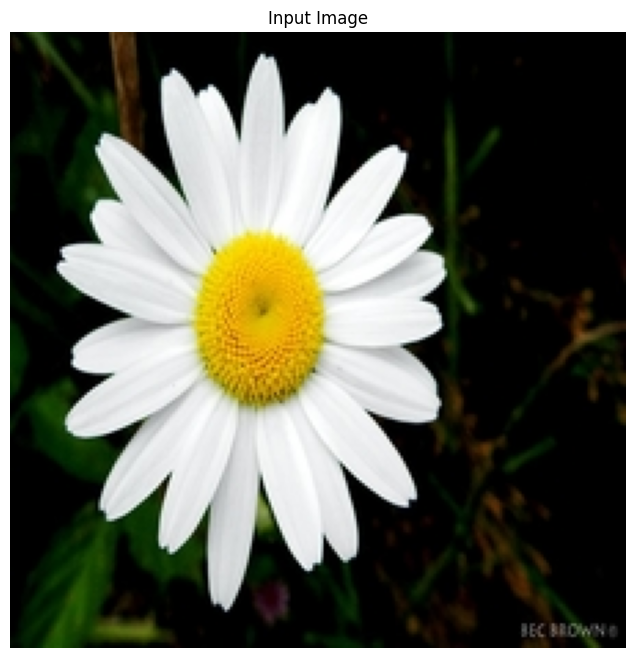

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import joblib
import matplotlib.pyplot as plt

# Function to preprocess image for different models
def preprocess_image(image_path, target_size):
    # Read image
    img = cv2.imread(image_path)
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize
    img = cv2.resize(img, target_size)
    # Normalize
    img = img.astype('float32') / 255.0
    return img

# Load and preprocess the prediction image
image_path = '/content/drive/MyDrive/Colab Notebooks/Additional CV/Prediction.jpg'

# Preprocess for different model requirements
img_224 = preprocess_image(image_path, (224, 224))
img_160 = preprocess_image(image_path, (160, 160))

# Add batch dimension
img_224_batch = np.expand_dims(img_224, axis=0)
img_160_batch = np.expand_dims(img_160, axis=0)

# Dictionary to store predictions
predictions = {}

# 1. CNN Models
cnn_models = {
    'Base CNN': ('/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models/base_model.keras', img_224_batch),
    'Deeper CNN': ('/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models/deeper_model.keras', img_160_batch),
    'Transfer Learning': ('/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models/transfer_model.keras', img_160_batch),
    'Fine-tuned': ('/content/drive/MyDrive/Colab Notebooks/Additional CV/cnn_models/fine_tuned_model.keras', img_160_batch)
}

# Load and predict with CNN models
for model_name, (model_path, img) in cnn_models.items():
    try:
        model = tf.keras.models.load_model(model_path)
        pred = model.predict(img)
        predictions[model_name] = np.argmax(pred[0])
        print(f"{model_name} prediction: Class {predictions[model_name]}")
    except Exception as e:
        print(f"Error with {model_name}: {str(e)}")

# 2. Neural Network Model
try:
    nn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Additional CV/nn_models/nn_models/best_model.keras')
    pred = nn_model.predict(img_224_batch)
    predictions['Neural Network'] = np.argmax(pred[0])
    print(f"Neural Network prediction: Class {predictions['Neural Network']}")
except Exception as e:
    print(f"Error with Neural Network: {str(e)}")

# 3. Random Forest Model
try:
    rf_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Additional CV/rf_models/rf_base.joblib')
    img_flat = img_224.reshape(1, -1)
    predictions['Random Forest'] = rf_model.predict(img_flat)[0]
    print(f"Random Forest prediction: Class {predictions['Random Forest']}")
except Exception as e:
    print(f"Error with Random Forest: {str(e)}")

# 4. SVM Models
svm_models = {
    'SVM Base': '/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models/svm_base_pipeline.joblib',
    'SVM Tuned': '/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models/svm_tuned_pipeline.joblib',
    'SVM Kernel PCA': '/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models/svm_kernel_pca_pipeline.joblib',
    'SVM Weighted': '/content/drive/MyDrive/Colab Notebooks/Additional CV/svm_models/svm_weighted_pipeline.joblib'
}

# Load and predict with SVM models
img_flat = img_224.reshape(1, -1)
for model_name, model_path in svm_models.items():
    try:
        model = joblib.load(model_path)
        predictions[model_name] = model.predict(img_flat)[0]
        print(f"{model_name} prediction: Class {predictions[model_name]}")
    except Exception as e:
        print(f"Error with {model_name}: {str(e)}")

# Display the input image
plt.figure(figsize=(8, 8))
plt.imshow(img_224)
plt.title('Input Image')
plt.axis('off')
plt.show()

# Print summary of all predictions
print("\nPrediction Summary:")
print("=" * 50)
for model_name, pred_class in predictions.items():
    print(f"{model_name:15} predicted Class {pred_class}")

In [ ]:
# Add the class mapping dictionary
class_names = {
    0: "bird of paradise",
    4: "peruvian lily",
    8: "barbeton daisy",
    13: "petunia"
}

print("\nPrediction Summary with Class Names:")
print("=" * 50)
for model_name, pred_class in predictions.items():
    class_name = class_names.get(pred_class, f"Unknown (Class {pred_class})")
    print(f"{model_name:20} predicted: {class_name}")


Prediction Summary with Class Names:
Base CNN             predicted: barbeton daisy
Deeper CNN           predicted: petunia
Transfer Learning    predicted: bird of paradise
Fine-tuned           predicted: bird of paradise
Random Forest        predicted: bird of paradise
SVM Base             predicted: petunia
SVM Tuned            predicted: petunia
SVM Kernel PCA       predicted: peruvian lily
SVM Weighted         predicted: petunia


The image shows a white daisy with a yellow center, and analyzing the predictions:

**Most Accurate Prediction:**

- Base CNN: "barbeton daisy" (Class 8):
This appears to be the most accurate prediction given the visual characteristics of the flower in the image.

**Pattern in Predictions:**

- Several models (Deeper CNN, SVM Base, SVM Tuned, SVM Weighted) predicted "petunia"
- Three models (Transfer Learning, Fine-tuned, Random Forest) predicted "bird of paradise"
- One model (SVM Kernel PCA) predicted "peruvian lily"

***Why Base CNN Might Have Performed Better:***

- Basic CNN architectures can sometimes be better at distinguishing simple, distinct features like the characteristic daisy shape
- The clear white petals and yellow center are typical daisy characteristics that the base CNN likely learned well

***Why Other Models Might Have Made Different Predictions:***

- Petunias can also be white, which might explain why several models predicted petunia
- The more complex models might be overfitting to certain features
- The image's lighting and angle might have confused some models